# Triplet Loss

### Load Train, Test, and Validation data

In [1]:
import numpy as np

In [2]:
train_features_path =  "../feature/BENGALI-feature/train_features.npy"
train_names_path = "../feature/BENGALI-feature/train_names.npy"
train_labels_path = "../feature/BENGALI-feature/train_labels.npy"

test_features_path = "../feature/BENGALI-feature/test_features.npy"
test_names_path = "../feature/BENGALI-feature/test_names.npy"
test_labels_path = "../feature/BENGALI-feature/test_labels.npy"

validation_features_path = "../feature/BENGALI-feature/validation_features.npy"
validation_names_path = "../feature/BENGALI-feature/validation_names.npy"
validation_labels_path = "../feature/BENGALI-feature/validation_labels.npy"

gallery_feature_path = "../feature/BENGALI-feature/gallery_features.npy"
gallery_name_path = "../feature/BENGALI-feature/gallery_names.npy"

train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

validation_features = np.load(validation_features_path)
validation_names = np.load(validation_names_path)
validation_labels = np.load(validation_labels_path)

gallery_features = np.load(gallery_feature_path)
gallery_names = np.load(gallery_name_path)

In [3]:
print(train_features.shape)
print(train_labels.shape)
print(train_names.shape)
print(test_features.shape)
print(test_labels.shape)
print(test_names.shape)
print(validation_features.shape)
print(validation_labels.shape)
print(validation_names.shape)
print(gallery_features.shape)
print(gallery_names.shape)

(3200, 512)
(3200,)
(3200,)
(1100, 512)
(1100,)
(1100,)
(1100, 512)
(1100,)
(1100,)
(100, 512)
(100,)


### Creating Triplets

In [4]:
unique_names = set(train_names.flatten())
sorted_names = sorted(unique_names)

In [5]:
print(sorted_names)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100']


In [6]:
print(gallery_names)

['001' '002' '003' '004' '005' '006' '007' '008' '009' '010' '011' '012'
 '013' '014' '015' '016' '017' '018' '019' '020' '021' '022' '023' '024'
 '025' '026' '027' '028' '029' '030' '031' '032' '033' '034' '035' '036'
 '037' '038' '039' '040' '041' '042' '043' '044' '045' '046' '047' '048'
 '049' '050' '051' '052' '053' '054' '055' '056' '057' '058' '059' '060'
 '061' '062' '063' '064' '065' '066' '067' '068' '069' '070' '071' '072'
 '073' '074' '075' '076' '077' '078' '079' '080' '081' '082' '083' '084'
 '085' '086' '087' '088' '089' '090' '091' '092' '093' '094' '095' '096'
 '097' '098' '099' '100']


In [7]:
def create_triplets(unique_names, gallery_features, features, labels):
    anchors, positives, negatives = [], [], []
    for name, gallery in zip(unique_names, gallery_features):
        # find all the instances for name
        indices = np.where(train_names == name)[0]
        # print(indices)
        
        # separate instances to positive and negative
        positive_set, negative_set = [], []
        for index in indices:
            # print(index)
            if labels[index] == 0:
                negative_set.append(features[index])
                # print(features[index])
            else:
                positive_set.append(features[index]) 

        negative_set = np.array(negative_set)
        positive_set = np.array(positive_set)

        # use feature gallery for anchor
        # print(gallery.size)
        anchor = gallery
        
        # print(positive_set.size)
        # print(negative_set.size)

        # randomize data picks to accomodate for unequal data size (total size is based on negative data size due to it being bigger than positive data size)
        np.random.seed(1)
        positive_idx = np.random.choice(len(positive_set), size=len(negative_set), replace=True)
        positive = positive_set[positive_idx]
        
        anchor_set = []
        for _ in range(0, len(negative_set)):
            anchor_set.append(anchor)

        anchors.append(anchor_set)
        positives.append(positive)
        negatives.append(negative_set)
        # print(len(anchors))
        # print(len(positives))
        # print(len(negatives))

    anchors = np.concatenate(anchors, axis=0)
    
    positives = np.concatenate(positives, axis=0)

    negatives = np.concatenate(negatives, axis=0)
    
    return anchors, positives, negatives

In [8]:
anchors, positives, negatives = create_triplets(sorted_names, gallery_features, train_features, train_labels)

In [9]:
print("Anchors shape:", anchors.shape)
print("Positives shape:", positives.shape)
print("Negatives shape:", negatives.shape)

Anchors shape: (1800, 512)
Positives shape: (1800, 512)
Negatives shape: (1800, 512)


### Triplet Loss Function

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [11]:
input_shape = (train_features.shape[1],)

In [12]:
embedding_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu')
])

In [13]:
def create_triplet_loss_model(embedding_model, input_shape):
    anchor_input = layers.Input(shape=input_shape, name='anchor_input')
    positive_input = layers.Input(shape=input_shape, name='positive_input')
    negative_input = layers.Input(shape=input_shape, name='negative_input')

    # Get embeddings
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    # Triplet loss function
    margin = 0.2
    positive_distance = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), axis=1)
    negative_distance = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), axis=1)
    loss = tf.maximum(0.0, positive_distance - negative_distance + margin)
    loss = tf.reduce_mean(loss)

    triplet_loss_model = models.Model(inputs=[anchor_input, positive_input, negative_input], outputs=loss)
    return triplet_loss_model

In [14]:
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
Total params: 426880 (1.63 MB)
Trainable params: 426880 (1.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
triplet_model = create_triplet_loss_model(embedding_model, input_shape)
triplet_model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
triplet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_input (InputLayer)   [(None, 512)]                0         []                            
                                                                                                  
 positive_input (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 negative_input (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

In [17]:
triplet_model.fit([anchors, positives, negatives], np.zeros_like(anchors), epochs=10, batch_size=32)

Epoch 1/10

57/57 [==============================] - 3s 9ms/step - loss: 0.0714
Epoch 2/10
57/57 [==============================] - 1s 9ms/step - loss: 0.0065
Epoch 3/10
57/57 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 4/10
57/57 [==============================] - 0s 9ms/step - loss: 1.7830e-05
Epoch 5/10
57/57 [==============================] - 1s 9ms/step - loss: 2.7957e-06
Epoch 6/10
57/57 [==============================] - 0s 9ms/step - loss: 2.1264e-06
Epoch 7/10
57/57 [==============================] - 0s 9ms/step - loss: 5.9752e-09
Epoch 8/10
57/57 [==============================] - 0s 9ms/step - loss: 0.0000e+00
Epoch 9/10
57/57 [==============================] - 1s 9ms/step - loss: 0.0000e+00
Epoch 10/10
57/57 [==============================] - 0s 8ms/step - loss: 0.0000e+00


In [18]:
from sklearn.metrics import accuracy_score

In [19]:
print(test_labels)

[1 1 1 ... 0 0 0]


In [20]:
train_predictions = embedding_model.predict(train_features)
validation_predictions = embedding_model.predict(validation_features)
test_predictions = embedding_model.predict(test_features)
gallery_predictions = embedding_model.predict(gallery_features)

4/4 [==============================] - 0s 5ms/step


In [21]:
print(train_predictions.shape)
print(validation_predictions.shape)
print(test_predictions.shape)
print(gallery_predictions.shape)

(3200, 128)
(1100, 128)
(1100, 128)
(100, 128)


In [22]:
# Feature Gallery dilakukan untuk setiap kelas / nama seperti "001", "002", "003", dst dengan cara mengambil data training positive dan mengambil mean / rata-rata dari data tersebut
def create_feature_gallery(train_features, train_names, train_labels):
    gallery_feature = []
    gallery_name = []

    unique_names = set(train_names.flatten())
    sorted_names = sorted(unique_names)

    for name in sorted_names:
        # print(name)
        # print(name)
        name_features = []

        for feature, feature_name, label in zip(train_features, train_names, train_labels):
            # print(feature, feature_name, label)
            if name in feature_name and label == 1:
                name_features.append(feature)

        if name_features:
            # print(name_features)
            average_feature = np.mean(name_features, axis=0)
            gallery_feature.append(average_feature)
            gallery_name.append(name)

    return gallery_feature, gallery_name

In [23]:
# gallery_features_extracted, gallery_names_extracted = create_feature_gallery(train_predictions, train_names, train_labels)

In [24]:
# print(gallery_features_extracted)

In [25]:
def euclidean_distance(feature_vector1, feature_vector2):
    return np.sqrt(np.sum((feature_vector1 - feature_vector2)**2))

In [26]:
def find_euclidean_distance(test_features, test_names, test_labels, gallery_features, gallery_names):
    euclidean_distances = []
    euclidean_names = []
    euclidean_actual_labels = []

    for gallery_feature, gallery_name in zip(gallery_features, gallery_names):
        curr_euclid_name = gallery_name
        curr_euclid_feature = []
        curr_euclid_label = []
        curr_euclid_dist = []
        for feature, name, label in zip(test_features, test_names, test_labels):
            if gallery_name in name:
                curr_euclid_feature.append(feature)
                curr_euclid_label.append(label)
        
        for feature in curr_euclid_feature:
            distance = euclidean_distance(feature, gallery_feature)
            curr_euclid_dist.append(distance)

        euclidean_distances.append(curr_euclid_dist)
        euclidean_names.append(curr_euclid_name)
        euclidean_actual_labels.append(curr_euclid_label)
        
    return euclidean_distances, euclidean_names, euclidean_actual_labels

In [27]:
test_euclidean_distances, test_euclidean_names, test_euclidean_actual_labels = find_euclidean_distance(test_predictions, test_names, test_labels, gallery_predictions, gallery_names)
train_euclidean_distances, train_euclidean_names, train_euclidean_actual_labels = find_euclidean_distance(train_predictions, train_names, train_labels, gallery_predictions, gallery_names)
validation_euclidean_distances, validation_euclidean_names, validation_euclidean_actual_labels = find_euclidean_distance(validation_predictions, validation_names, validation_labels, gallery_predictions, gallery_names)

### Normalize Euclidean Distance

In [28]:
# Flatten the lists of distances
flat_test_distances = [item for sublist in test_euclidean_distances for item in sublist]
flat_train_distances = [item for sublist in train_euclidean_distances for item in sublist]
flat_validation_distances = [item for sublist in validation_euclidean_distances for item in sublist]

In [29]:
print(flat_train_distances)

[1.8968247, 1.3427002, 1.1699826, 1.5619707, 1.4989467, 1.6134427, 1.9269124, 1.3362434, 1.1011591, 1.5621283, 2.0822022, 1.8283999, 2.6449294, 1.7540523, 4.602803, 5.061256, 4.8765345, 3.3586679, 4.879777, 4.910127, 4.8293805, 6.534127, 5.6623635, 4.1581254, 6.201302, 5.824031, 5.656358, 4.3618855, 4.2318926, 4.831016, 5.4796906, 6.580495, 1.3988752, 1.105819, 1.3458608, 0.97724456, 1.4195906, 1.5127174, 1.5723871, 1.30916, 1.224262, 1.7926824, 1.0454005, 2.1455255, 1.293828, 1.2351322, 3.2570374, 4.4530563, 6.214325, 2.5724075, 4.0965176, 4.0391164, 5.7018814, 4.1553736, 3.8531373, 4.3892336, 5.1863523, 5.2278733, 5.0256343, 4.0917783, 4.975368, 5.024962, 3.2940176, 5.7462564, 2.0439353, 1.3183986, 1.9044628, 2.1904573, 1.9096216, 3.7519853, 1.653921, 1.9096216, 2.094719, 2.1904573, 1.9044628, 1.9096216, 2.094719, 2.1904573, 4.7257338, 4.8422127, 5.954277, 5.9734983, 4.7306843, 5.9646816, 5.950694, 4.5334754, 4.563724, 5.1885777, 5.5541587, 4.9402194, 5.54149, 5.19618, 5.7781243, 6.3

In [30]:
def get_min_max(euclidean_distances):
    min_distance = min(euclidean_distances)
    max_distance = max(euclidean_distances)

    return min_distance, max_distance

In [31]:
min_val, max_val = get_min_max(flat_train_distances)
print(f'min: {min_val}, max: {max_val}')

min: 0.5408449172973633, max: 8.186495780944824


In [32]:
def normalize_distance(euclidean_distances, min_val, max_val):
    all_distance = []

    for distance in euclidean_distances:
        normalized_distance = (distance - min_val) / (max_val - min_val)

        # in case test and train distances are beyond max of train
        if normalized_distance > 1:
            normalized_distance = 1
        elif normalized_distance < 0:
            normalized_distance = 0
        
        all_distance.append(normalized_distance)

    return all_distance

def reverse_normalized_distance(euclidean_distances, min_val, max_val):
    reverse_distance = []
    normalized_distances = normalize_distance(euclidean_distances, min_val, max_val)
    for distance in normalized_distances:
        distance = -distance
        reverse_distance.append(distance)

    return reverse_distance

In [33]:
normalized_test_euclidean_distance = reverse_normalized_distance(flat_test_distances, min_val, max_val)
normalized_train_euclidean_distance = reverse_normalized_distance(flat_train_distances, min_val, max_val)
normalized_validation_euclidean_distance = reverse_normalized_distance(flat_validation_distances, min_val, max_val)

In [34]:
print(normalized_test_euclidean_distance)

[-0.13181657, -0.18286604, -0.23331328, -0.11065733, -0.112555236, -0.3744896, -0.65250975, -0.7073762, -0.6101448, -0.4640567, -0.7554715, -0.15298589, -0.11223222, -0.07326639, -0.14989503, -0.13924092, -0.51259774, -0.6020884, -0.43796802, -0.43338385, -0.35940093, -0.47773737, -0.16051199, -0.14059544, -0.20323633, -0.15292671, -0.1783521, -0.75437117, -0.52119344, -0.62052643, -0.6377389, -0.79028714, -0.54115033, -0.45445648, -0.43142802, -0.23110539, -0.1539397, -0.42733198, -0.58293617, -0.5378739, -0.60265875, -0.5384159, -0.398521, -0.5177265, -0.26352125, -0.20152551, -0.25308374, -0.22947468, -0.19045307, -0.21608299, -0.31790534, -0.30075085, -0.43968365, -0.432188, -0.3143098, -0.37224278, -0.13249649, -0.18773104, -0.19614987, -0.22918165, -0.26470423, -0.40801775, -0.3551946, -0.3533518, -0.3544762, -0.40313283, -0.32101014, -0.24766342, -0.26181248, -0.24628358, -0.21470682, -0.5743376, -0.49557588, -0.5152865, -0.49557588, -0.6110369, -0.70841223, -0.16146073, -0.1764

# 3. ROC Curve

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

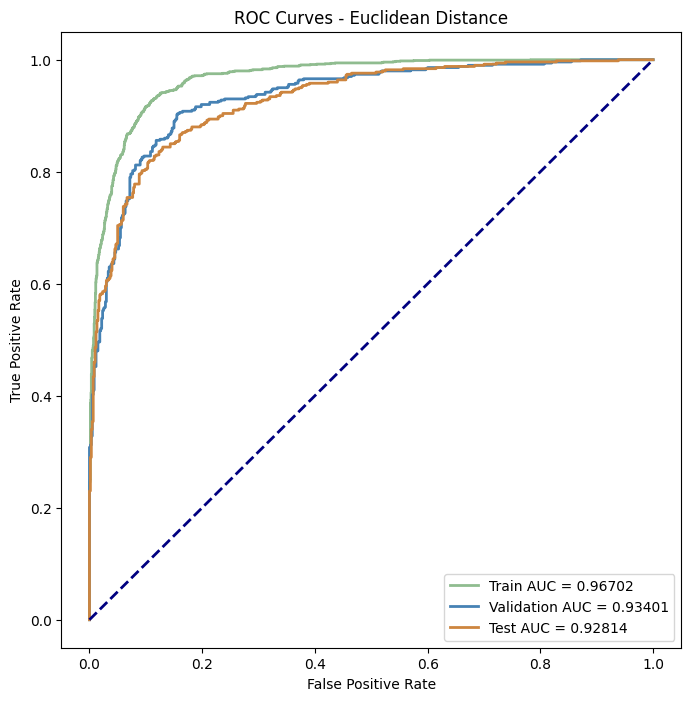

In [36]:
# Flatten the lists of labels
flat_test_labels = [item for sublist in test_euclidean_actual_labels for item in sublist]
flat_train_labels = [item for sublist in train_euclidean_actual_labels for item in sublist]
flat_validation_labels = [item for sublist in validation_euclidean_actual_labels for item in sublist]

# Calculate ROC curve
fpr_test, tpr_test, thresholds_test = roc_curve(flat_test_labels, normalized_test_euclidean_distance, drop_intermediate=False)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, thresholds_train = roc_curve(flat_train_labels, normalized_train_euclidean_distance, drop_intermediate=False)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_validation, tpr_validation, thresholds_validation = roc_curve(flat_validation_labels, normalized_validation_euclidean_distance, drop_intermediate=False)
roc_auc_validation = auc(fpr_validation, tpr_validation)

# Plot ROC curve
plt.figure(figsize=(8, 8))

plt.plot(fpr_train, tpr_train, color='darkseagreen', lw=2, label=f'Train AUC = {roc_auc_train:.5f}')
plt.plot(fpr_validation, tpr_validation, color='steelblue', lw=2, label=f'Validation AUC = {roc_auc_validation:.5f}')
plt.plot(fpr_test, tpr_test, color='peru', lw=2, label=f'Test AUC = {roc_auc_test:.5f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Euclidean Distance')
plt.legend(loc='lower right')
plt.show()

In [37]:
print(tpr_test)

[0.    0.002 0.004 ... 1.    1.    1.   ]


In [38]:
print(fpr_test)

[0.         0.         0.         ... 0.995      0.99666667 1.        ]


In [39]:
def find_tpr_at_fpr(fpr, tpr, target_fpr):
    return np.interp(target_fpr, fpr, tpr)

In [40]:
target_fprs = [0.1, 0.01, 0.001]
tpr_at_target_fpr_train = [find_tpr_at_fpr(fpr_train, tpr_train, fpr) for fpr in target_fprs]
tpr_at_target_fpr_test = [find_tpr_at_fpr(fpr_test, tpr_test, fpr) for fpr in target_fprs]
tpr_at_target_fpr_val = [find_tpr_at_fpr(fpr_validation, tpr_validation, fpr) for fpr in target_fprs]

In [41]:
print("Train")
for tpr, fpr in zip(tpr_at_target_fpr_train, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_train}')

print("Validation")
for tpr, fpr in zip(tpr_at_target_fpr_val, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_validation}')

print("Test")
for tpr, fpr in zip(tpr_at_target_fpr_test, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_test}')


Train
TPR at FPR 0.100: 0.916
TPR at FPR 0.010: 0.567
TPR at FPR 0.001: 0.246
             AUC: 0.9670234126984127
Validation
TPR at FPR 0.100: 0.828
TPR at FPR 0.010: 0.452
TPR at FPR 0.001: 0.308
             AUC: 0.9340066666666665
Test
TPR at FPR 0.100: 0.804
TPR at FPR 0.010: 0.486
TPR at FPR 0.001: 0.230
             AUC: 0.9281433333333334


In [42]:
train_features_triplet_loss_path =  "../feature/BENGALI-feature/train_features_triplet_loss.npy"
validation_features_triplet_loss_path = "../feature/BENGALI-feature/validation_features_triplet_loss.npy"
test_features_triplet_loss_path = "../feature/BENGALI-feature/test_features_triplet_loss.npy"
gallery_features_triplet_loss_path = "../feature/BENGALI-feature/gallery_features_triplet_loss.npy"

In [43]:
np.save(train_features_triplet_loss_path, train_predictions)
np.save(test_features_triplet_loss_path, test_predictions)
np.save(validation_features_triplet_loss_path, validation_predictions)
np.save(gallery_features_triplet_loss_path, gallery_predictions)